In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
sys.path.append("FixedStrides")
from main import *
results_wolant = pd.read_csv('ip32_wolant_results.csv', sep=';')
results_fst = pd.read_csv('ip32_fst_results.csv', sep=';')
results_equal_dist = pd.read_csv('ip32_equal_dist_results.csv', sep=';')
# results_au = pd.read_csv('ipResults_home_gtx980_australia.csv', sep=';')
# results_au_32bit = pd.read_csv('ip_32bit_au.csv', sep=';')
# results_tokyo = pd.read_csv('ip_32bit_tokyo.csv', sep=';')
# results_au_32bit.drop(results_au_32bit.columns[len(results_au_32bit.columns)-1], axis=1, inplace=True)  # delete NaN column
# results_tokyo.drop(results_tokyo.columns[len(results_tokyo.columns)-1], axis=1, inplace=True)  # delete NaN column

In [2]:
def plot_prefix_distribution(prefixes):
    lengths = utils.get_lengths(prefixes)
    plt.bar(range(1, len(lengths) + 1), lengths, align='center')
    plt.xlabel('Prefix length in bits')
    plt.ylabel('Num occurrences')
    plt.title('Prefix length distribution')
    plt.show()

In [3]:
# prefixes_au = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_australia_012016.txt')
prefixes_tokyo = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_tokyo_012016.txt')
node_counts_tokyo = utils.get_node_counts(prefixes_tokyo)

Read 576846 prefixes from file in 8.712145566940308 seconds


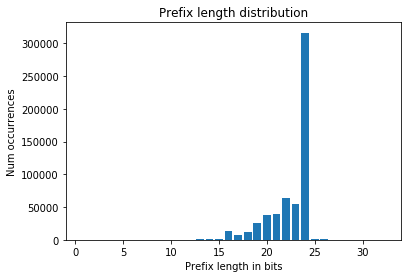

In [4]:
# plot_prefix_distribution(prefixes_au)
plot_prefix_distribution(prefixes_tokyo)

In [5]:
def get_empty_node_stats(tree_levels, strides):
    # Calculate number of empty child pointers in all nodes at each level
    # For example, if we have 100 nodes in level 1 (second level)
    # And the config for root node is 8, then it means the root node has 2^8 - 100 empty/null child pointers
    # TODO move this to utils.get_stats()
    num_empty_pointers_per_lvl = []
    percentage_empty_pointers_per_lvl = []
    total_num_pointers = 0
    for i in range(len(tree_levels) - 1):
        total_num_pointers_in_curr_lvl = tree_levels[i] * (2 ** strides[i])
        num_empty_pointers_in_curr_lvl = total_num_pointers_in_curr_lvl - tree_levels[i + 1]
        total_num_pointers += total_num_pointers_in_curr_lvl
        num_empty_pointers_per_lvl.append(num_empty_pointers_in_curr_lvl)
        percentage_empty_pointers_per_lvl.append(float(round(100 * num_empty_pointers_in_curr_lvl / total_num_pointers_in_curr_lvl, 2)))
    total_empty_pointer_percentage = float(round(100 * sum(num_empty_pointers_per_lvl) / total_num_pointers, 2))
    return num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage
        


def append_stats(row: pd.Series, nodes: list):
    strides = row['Config'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    strides = [int(x) for x in strides]
    tree_levels = row['TreeLevels'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    tree_levels = [int(x) for x in tree_levels]
    num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage = get_empty_node_stats(tree_levels, strides)
    num_empty_pointers_per_lvl = str(num_empty_pointers_per_lvl)
    percentage_empty_pointers_per_lvl = str(percentage_empty_pointers_per_lvl)
    tmp, strides_nodes, cost, percent = utils.get_stats(nodes, strides, ignore_last_level=True)
    build_and_find = float(row['Build']) + float(row['Find'])
    build_and_match = float(row['Build']) + float(row['Match'])
    match_and_find = float(row['Match']) + float(row['Find'])
    return pd.Series([cost, percent, build_and_find, build_and_match, match_and_find, num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage])

def append_stats_to_df(df: pd.DataFrame):
    newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels', 'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage']
    # For now assume Tokyo dataset
    newcols = df.apply(lambda row: append_stats(row, node_counts_tokyo), axis=1)
    newcols.columns = newcol_names
    return df.join(newcols)

In [6]:
results_wolant = append_stats_to_df(results_wolant)
results_fst = append_stats_to_df(results_fst)
results_equal_dist = append_stats_to_df(results_equal_dist)

In [7]:
# results_wolant = results_wolant.sort_values('RandomMatch')
# results_wolant[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_fst = results_fst.sort_values('RandomMatch')
# results_fst[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_equal_dist = results_equal_dist.sort_values('Match')
# results_equal_dist[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

In [17]:
results_wolant = results_wolant.sort_values('RandomMatch')
results_wolant[['Config', 'RandomMatch', 'Match', 'Find', 'TotalEmptyPointerPercentage', 'TreeMemoryUniqueOnly', 'ContainerStartsMemory', 'ContainerLengthsMemory', 'ChildrenMemory', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,Find,TotalEmptyPointerPercentage,TreeMemoryUniqueOnly,ContainerStartsMemory,ContainerLengthsMemory,ChildrenMemory,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
11,"{8, 2, 2, 2, 2, 2, 2, 2, 2, 8}",0.650720,1.127872,25.888224,73.57,2946048,110488,110448,417608,84.808467,"[83.98, 57.32, 40.71, 38.7, 41.95, 48.92, 34.2...",35.509537,"{1,41,70,166,407,945,1931,5078,17394,1559,}","[215, 94, 114, 257, 683, 1849, 2646, 2918, 68017]"
7,"{8, 4, 4, 2, 2, 2, 2, 8}",0.724096,1.075936,26.869375,74.17,2944456,108556,108524,419896,84.516228,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 97.76]",26.506687,"{1,41,166,945,1931,5078,17394,1559,}","[215, 490, 1711, 1849, 2646, 2918, 68017]"
2,"{8, 4, 4, 4, 4, 8}",0.733568,1.630784,35.900513,92.21,2769680,31232,31208,399784,121.297492,"[83.98, 74.7, 64.42, 66.42, 98.08]",23.518976,"{1,41,166,945,5078,1559,}","[215, 490, 1711, 10042, 79689]"
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.914688,2.119424,8.627616,49.99,3551560,311152,311024,621616,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",82.221184,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
10,"{4, 5, 4, 5, 6, 4, 2, 2}",1.187360,4.268256,38.719616,97.55,2972080,15632,15600,633368,220.251056,"[12.5, 88.39, 68.75, 76.79, 98.74, 99.82, 88.59]",27.005280,"{1,14,52,260,1931,1559,46,21,}","[2, 396, 572, 6389, 122025, 24898, 163]"
9,"{4, 4, 4, 4, 8, 8}",2.493312,10.905952,60.429665,98.89,3311312,10976,10952,981928,338.673358,"[12.5, 81.7, 74.7, 64.42, 99.36]",22.647167,"{1,14,41,166,945,1559,}","[2, 183, 490, 1711, 240361]"
6,"{8, 8, 4, 2, 2, 8}",8.312000,0.916128,34.405281,78.39,2970800,100144,100120,463080,87.575566,"[83.98, 91.0, 66.42, 14.37, 97.76]",23.900480,"{1,41,945,5078,17394,1559,}","[215, 9551, 10042, 2918, 68017]"
3,"{8, 8, 2, 2, 2, 2, 8}",8.366976,1.063584,26.712320,75.97,2971824,107880,107852,448624,84.895772,"[83.98, 91.0, 48.92, 34.26, 14.37, 97.76]",25.757183,"{1,41,945,1931,5078,17394,1559,}","[215, 9551, 1849, 2646, 2918, 68017]"
5,"{8, 8, 4, 4, 8}",8.424512,1.660352,35.296062,92.88,2797048,30556,30536,428512,121.677036,"[83.98, 91.0, 66.42, 98.08]",22.844160,"{1,41,945,5078,1559,}","[215, 9551, 10042, 79689]"
8,"{8, 8, 16}",8.901920,10.851552,60.017151,90.83,2358400,3984,3972,43024,3.271119,"[83.98, 91.0]",15.291392,"{1,41,945,}","[215, 9551]"


In [15]:
results_fst = results_fst.sort_values('RandomMatch')
results_fst[['Config', 'RandomMatch', 'Match', 'Find', 'TotalEmptyPointerPercentage', 'ChildrenMemory', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeMemoryUniqueOnly', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,Find,TotalEmptyPointerPercentage,ChildrenMemory,Percent,PercentEmptyPointerLevels,Build,TreeMemoryUniqueOnly,TreeLevels,EmptyPointerLevels
10,"{8, 4, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",0.620192,1.072736,26.937216,57.67,580496,90.136753,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",35.011967,3379696,"{1,41,166,945,1931,5078,17394,33779,1559,442,6...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
11,"{8, 4, 4, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3}",0.674336,1.112448,26.982592,56.64,576168,90.109119,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",36.525566,3383536,"{1,41,166,945,1931,5078,17394,33779,1559,1017,...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
0,"{3, 5, 4, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2}",0.739328,1.346144,29.285601,74.17,445240,84.788536,"[0.0, 83.98, 74.7, 64.42, 48.92, 34.26, 14.37,...",42.106689,2983040,"{1,8,41,166,945,1931,5078,17394,1559,1017,442,...","[0, 215, 490, 1711, 1849, 2646, 2918, 68017, 2..."
12,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.768320,2.867552,8.588704,49.99,621616,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",78.216515,3551560,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
8,"{12, 4, 2, 2, 2, 1, 1, 2, 2, 4}",1.723584,1.105120,26.764704,58.81,595744,90.201315,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",29.530624,3394176,"{1,166,945,1931,5078,17394,33779,1559,442,46,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
9,"{12, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",1.773728,1.036608,26.770144,58.60,593224,90.168056,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",34.499870,3392064,"{1,166,945,1931,5078,17394,33779,1559,442,63,30,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
7,"{12, 4, 2, 2, 2, 1, 1, 3, 5}",1.790464,0.977568,26.644768,60.29,613608,90.352937,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",27.540192,3408608,"{1,166,945,1931,5078,17394,33779,1559,63,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 12..."
6,"{13, 4, 3, 2, 1, 1, 3, 5}",2.809760,1.001952,31.629633,62.38,632224,91.418692,"[96.83, 68.27, 51.91, 14.37, 2.9, 97.69, 99.49]",25.935072,3415496,"{1,260,1320,5078,17394,33779,1559,63,}","[7932, 2840, 5482, 2918, 1009, 65999, 12409]"
4,"{17, 3, 2, 1, 1, 8}",45.996258,0.790784,35.890015,77.63,1057200,93.501291,"[98.99, 51.91, 14.37, 2.9, 97.69]",23.324896,3837824,"{1,1320,5078,17394,33779,1559,}","[129752, 5482, 2918, 1009, 65999]"
5,"{17, 3, 2, 1, 1, 3, 5}",46.581600,1.072160,36.007519,78.61,1107096,93.986481,"[98.99, 51.91, 14.37, 2.9, 97.69, 99.49]",23.791649,3888256,"{1,1320,5078,17394,33779,1559,63,}","[129752, 5482, 2918, 1009, 65999, 12409]"


In [10]:
results_equal_dist = results_equal_dist.sort_values('RandomMatch')
results_equal_dist[['Config', 'RandomMatch', 'Match', 'Find', 'TotalEmptyPointerPercentage', 'ChildrenMemory', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeMemoryUniqueOnly', 'TreeLevels', 'EmptyPointerLevels']]

,Config,RandomMatch,Match,Find,TotalEmptyPointerPercentage,ChildrenMemory,Percent,PercentEmptyPointerLevels,Build,TreeMemoryUniqueOnly,TreeLevels,EmptyPointerLevels
4,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.734656,2.038432,8.596704,49.99,621616,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",79.047615,3551560,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
3,"{20, 1, 1, 1, 1, 8}",195.837479,0.980288,181.345596,94.32,4717848,136.816479,"[99.52, 9.54, 5.33, 2.9, 97.69]",22.443392,7561408,"{1,5078,9187,17394,33779,1559,}","[1043498, 969, 980, 1009, 65999]"
2,"{20, 2, 1, 1, 8}",196.168259,1.351552,181.030594,95.06,4684968,132.745921,"[99.52, 14.37, 2.9, 97.69]",20.450464,7455000,"{1,5078,17394,33779,1559,}","[1043498, 2918, 1009, 65999]"
1,"{21, 2, 1, 8}",282.659149,0.762592,321.720428,97.98,8805856,185.513142,"[99.56, 8.08, 97.69]",20.361055,11469576,"{1,9187,33779,1559,}","[2087965, 2969, 65999]"
0,"{22, 1, 9}",437.912567,29.562304,708.138367,98.79,16916384,275.912299,"[99.59, 2.9]",18.119295,19633256,"{1,17394,33779,}","[4176910, 1009]"


In [11]:
results_equal_dist.columns
# newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind']
# newcols_au = results_au_32bit.apply(lambda row: append_stats(row, nodes_au), axis=1)
# newcols_tokyo = results_tokyo.apply(lambda row: append_stats(row, nodes_tokyo), axis=1)
# newcols_au.columns = newcol_names
# newcols_tokyo.columns = newcol_names
# results_au_32bit = results_au_32bit.join(newcols_au)
# results_tokyo = results_tokyo.join(newcols_tokyo)
# results_au_32bit = results_au_32bit.sort_values('MatchAndFind')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_tokyo = results_tokyo.sort_values('TreeMemoryUniqueOnly')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_au_32bit = results_au_32bit.sort_values('TreeMemoryUniqueOnly')
# results_au_32bit[['Config', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'TreeLevels', 'ChildrenMemory', 'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_tokyo = results_tokyo.sort_values('Match')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit = results_tokyo.sort_values('Find')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Match'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Find'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Build'])
# results_tokyo['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['Match'].corr(results_au_32bit['Cost'])
# results_tokyo['Match'].corr(results_au_32bit['Cost'])

Index(['deviceId', 'deviceName', 'Dictionary', 'Load', 'Count', 'Sort',
       'Config', 'Reshape', 'Build', 'TreeMemory', 'TreeLevels', 'Depth',
       'TreeMemoryUniqueOnly', 'ChildrenMemory', 'ChildrenCountsMemory',
       'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory',
       'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory',
       'ContainerStartsMemory', 'ContainerLengthsMemory', 'Find', 'Match',
       'RandomCount', 'RandomMatch', 'RandomSort', 'RandomSortedMatch',
       'HitRate', 'Unnamed: 31', 'Cost', 'Percent', 'BuildAndFind',
       'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels',
       'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage'],
      dtype='object')